In [9]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
from mpl_toolkits.basemap import Basemap
import random
import matplotlib.patches as patches

In [10]:
constellation = "starlink"
path = "../../tle/"
max_isl = 4782.174752610824
# batch = [48, 45, 47, 47, 55, 52, 55, 51, 53, 53, 50, 51, 47, 44, 42, 57, 56, 49, 54, 60, 55, 26, 60, 56, 57, 51, 1, 41, 46, 52, 47, 46, 38, 7, 10]

## No need to run

In [11]:
# 3个月传播数据
cbf_file = path + constellation + "_u_pos_cbf_3_month.npy"
pos_file = path + constellation + "_u_pos_3_month.npy"

pos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
print(type(pos_cbf[0][0][0]))
print(pos_cbf[0][0])
print(np.shape(pos_cbf))

pos=np.load(pos_file,allow_pickle=True).tolist()
print(type(pos[0][0][0]))
print(pos[0][0])
print(np.shape(pos))

node_num = len(pos)
cycle = len(pos[0])

<class 'float'>
[-6053.995926609168, -874.6018578643767, 3238.421525132463]
(1686, 15840, 3)
<class 'float'>
[27.923081914311325, -0.8406291481134366, 547.7352901960046]
(1686, 15840, 3)


In [12]:
# 筛选过滤后卫星对应的位置信息
def read_txt(file):
    r = []
    with open(file,"r") as f:
        line = f.readline()
        while line:
            r.append(int(line.strip('\n')))
            line = f.readline()
    return r
f_keys = read_txt("../../tle/data/filtered_index.txt")
print(len(f_keys))

def filter_pos():
    r, rr = [], []
    for item in f_keys:
        r.append(pos_cbf[item])
        rr.append(pos[item])
    return r, rr
pos_cbf, pos = filter_pos()
print(np.shape(pos_cbf), np.shape(pos))

node_num = len(pos)
cycle = len(pos[0])

1541
(1541, 15840, 3) (1541, 15840, 3)


In [13]:
np.save('./data/pos.npy',pos)

In [10]:
def ger_sat_latlon(flag, time_in):
    r = []
    if flag == "single":
        for i in range(node_num):
            tmp = []
            for t in range(cycle):
                tmp.append([pos[i][t][0], pos[i][t][1]])
            r.append(tmp)
    else:
        for i in range(node_num):
            r.append([pos[i][time_in][0], pos[i][time_in][1]])
    return r

plot_time = 0
sat_latlon = ger_sat_latlon("nsingle", plot_time)
print(np.shape(sat_latlon), sat_latlon[0])

(1541, 2) [27.923081914311325, -0.8406291481134366]


In [11]:
file = "../../tle/data/filtered_3_month.csv"
# file = "./data/sat_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
data = df[0].str.split(',').values.tolist()
print(np.shape(data), data[0])
node_num = len(data)

tle_file = path + "tle_starlink_3_month_0401_0712.npy"
tle_data = np.load(tle_file, allow_pickle=True)
print("type: ", type(tle_data.item()))
tle_item = tle_data.item()
print("type: ", type(tle_item))
tle = tle_item.items()
d = {}
for k,v in tle:
    d[k] = v # v是多维的，两个月左右的数据，采样粒度可能有区别
print("Total: ",len(d), d['47150'][0])

keys = [item[0] for item in data]
print("Number of satellite: ", len(keys))

(1541, 2) ['44713', '19074A']
type:  <class 'dict'>
type:  <class 'dict'>
Total:  1701 ['2022-04-01 05:20:18', '1 47150U 20088AE  22091.22243163  .00004265  00000-0  30493-3 0  9991', '2 47150  53.0541 269.1438 0001347  72.7409 287.3727 15.06410475 75421', '6925.316']
Number of satellite:  1541


In [12]:
# 读入卫星所在轨道信息
file = "../../tle/data/sat_orbits_filtered_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
df.drop(labels=None,axis=0, index=0, columns=None, inplace=True)
sat_data = df[0].str.split(',').values.tolist()
print(np.shape(sat_data), sat_data[0])

filtered_keys = []
for item in sat_data:
    filtered_keys.append(item[-1])
print(len(filtered_keys))

def establish_dict():
    d = {}
    for item in sat_data:
        d[item[-1]] = int(item[0])
    return d
name2orbit = establish_dict()
print(len(name2orbit))

def read_sat_orbit():
    d = {}
    for i in range(len(sat_data)):
        if int(sat_data[i][0]) not in d:
            d[int(sat_data[i][0])] = [keys.index(sat_data[i][2])]
        else:
            d[int(sat_data[i][0])].append(keys.index(sat_data[i][2]))
    return d
sat_orbit = read_sat_orbit()
print(len(sat_orbit), sat_orbit[1])

(1409, 3) ['1', '5', '45182']
1409
1409
72 [145, 147, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 184, 747, 753, 785]


In [13]:
# 每个轨道内卫星根据经度排序
def sort_sat_lon(t):
    rr = []
    for o in sat_orbit:
        r = []
        for sat in sat_orbit[o]:
            lon = pos[sat][t][1]
            r.append([sat, lon])
        r = sorted(r, key = lambda x: x[1])
        r = [item[0] for item in r]
        rr.append(r)
    return rr
sorted_sat = sort_sat_lon(0)
print(np.shape(sorted_sat), sorted_sat[0])

(72,) [753, 161, 160, 167, 172, 164, 169, 747, 147, 163, 145, 184, 170, 171, 168, 166, 162, 785]


In [14]:
# 确定所有轨道0号卫星
sat_dir = np.load("../../tle/data/sat_dir_3_month.npy", allow_pickle=True).tolist()
print("sat direction shape: ", len(sat_dir))
def sat_0(t):
    max_isl = 4782.174752610824
    rr = []
    for o in range(len(sorted_sat)):
        r = []
        for sat in sorted_sat[o]:
            if sat_dir[sat] == 1:
                r.append([sat, abs(0 - pos[sat][t][0])])
        r = sorted(r, key = lambda x: x[1])
        sat0 = r[0][0]
        rr.append(sat0)
    return rr
sat0 = sat_0(0)
print("initial satellite: ", sat0, len(sat0))

def is_connected(t):
    flag = False
    for i in range(len(sat0)):
        x1, y1, z1 = pos_cbf[sat0[i]][t][0], pos_cbf[sat0[i]][t][1], pos_cbf[sat0[i]][t][2]
        x2, y2, z2 = pos_cbf[sat0[i-1]][t][0], pos_cbf[sat0[i-1]][t][1], pos_cbf[sat0[i-1]][t][2]
        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
        dir1, dir2 = sat_dir[sat0[i]], sat_dir[sat0[i-1]]
        if dis < max_isl and dir1 == dir2:
            flag = True
        if not flag:
            return False
    return True
print(is_connected(0))    

sat direction shape:  1541
initial satellite:  [785, 792, 345, 852, 159, 899, 329, 745, 306, 871, 290, 1162, 273, 1195, 451, 1212, 249, 1404, 423, 1383, 412, 1341, 235, 1358, 598, 1126, 590, 580, 215, 1136, 562, 1281, 1295, 1311, 359, 908, 34, 913, 373, 1010, 940, 970, 365, 646, 134, 994, 638, 981, 1019, 1033, 499, 704, 100, 718, 497, 1086, 702, 1077, 459, 668, 75, 542, 675, 1265, 1248, 1240, 524, 1215, 179, 822, 535, 833] 72
True


In [15]:
# 再次排序,0号卫星在左侧
def sort_sat0():
    r = []
    for i in range(len(sorted_sat)):
        tmp = sorted_sat[i]
        ini = tmp.index(sat0[i])
        tmp1, tmp2 = tmp[:ini], tmp[ini:]
        tmp2.extend(tmp1)
        r.append(tmp2)
    return r
sorted_sat_0 = sort_sat0()
print(len(sorted_sat), sorted_sat_0[0])
# [270, 1406, 267, 284, 265, 263, 259, 262, 260, 258, 274, 272, 275, 264, 273, 271, 268, 269, 261]
# [1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176]

72 [785, 753, 161, 160, 167, 172, 164, 169, 747, 147, 163, 145, 184, 170, 171, 168, 166, 162]


In [16]:
np.save('./data/sorted_sat_0.npy',sorted_sat_0)

#### 邻居建链示意图

In [7]:
# 读取0时刻拓扑信息
intra_0 = np.load("./data/intra_t0.npy", allow_pickle=True).item()
inter_0 = np.load("./data/inter_t0.npy", allow_pickle=True).item()

In [13]:
# 获取卫星位置 [len(arr), , 2]
def extract_sat(arr, t):
    r = []
    for i in arr:
        tmp = {}
        sats = sorted_sat_0[i]
        for sat in sats:
            tmp[sat] = [pos[sat][t][0], pos[sat][t][1]]
        r.append(tmp)
    return r
sat_pos = extract_sat([0,1,2], 0)
print(len(sat_pos))

3


In [4]:
# 获取上述卫星的连接关系
def extract_neigh(orbits):
    intra, inter = {}, {}
    for orbit in orbits:
        sats = sorted_sat_0[orbit]
        for sat in sats:
            # print(sat, intra_0[sat])
            intra[sat] = intra_0[sat][-1]
    for i in range(1,len(orbits)-1):
        orbit = orbits[i]
        sats = sorted_sat_0[orbit]
        for sat in sats:
            inter[sat] = inter_0[sat]
    return intra, inter

In [22]:
np.save('sat_pos.npy',sat_pos)

In [23]:
intra, inter = extract_neigh([0,1,2])
np.save('intra.npy',intra)
np.save('inter.npy',inter)

## Start from this line

In [15]:
sorted_sat_0 = np.load('./data/sorted_sat_0.npy',allow_pickle=True).tolist()
sat_pos = np.load('./data/sat_pos.npy',allow_pickle=True).tolist()
intra = np.load('./data/intra.npy',allow_pickle=True).item()
inter = np.load('./data/inter.npy',allow_pickle=True).item()
pos = np.load('./data/pos.npy',allow_pickle=True).tolist()
node_num = len(pos)
cycle = len(pos[0])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


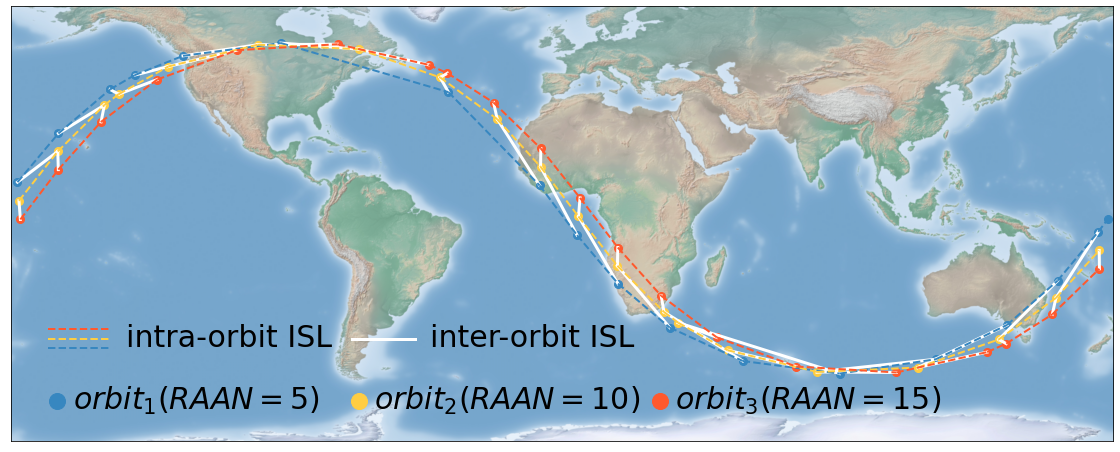

In [16]:
def plot_sat_time(t):
    font={'family' : 'Arial',
      'weight':'bold',
      'size':30
    }
    
    fig = plt.figure(figsize=(25, 8), edgecolor='w')
    left_bound, right_bound = -180, 175
    up_bound, bottom_bound = 65, -75
    
    m = Basemap(projection='cyl', llcrnrlat=bottom_bound, urcrnrlat=up_bound,
                llcrnrlon=left_bound, urcrnrlon=right_bound, ) # , resolution=None, # 左下角的纬度，右上角的纬度，左下角的经度，右上角的经度
#     m.drawcoastlines(color='black', linewidth=0.5)
#     m.fillcontinents(color='white', lake_color='#AECCF2')
#     m.drawmapboundary(fill_color='#AECCF2')
    m.shadedrelief(scale=0.2)
    
    #colors=['red','orange','yellow','green','blue','black','purple']
    #colors=['#33A650','#448FF2','#F23838', 'yellow', '#27E33B', '#5367FC','#000000']
    colors = ["#3787C0", "#FFCD43","#FF592D","#00A491"]
    
    for i in range(len(sat_pos)):
        sats = sat_pos[i]
        for key in sats:
            lat, lon = sats[key]
            m.plot(lon, lat, 'o', color=colors[i], markersize=8)
            
    intra, inter = extract_neigh([0,1,2])
    # inter-ISL
    for sat in inter:
        neighs = inter[sat]
        for neigh in neighs:
            lats = [pos[sat][t][0], pos[neigh][t][0]]
            lons = [pos[sat][t][1], pos[neigh][t][1]]
            if abs(lons[0] - lons[1]) < 180:
                m.plot(lons, lats, '-', linewidth = 3, color="w")
    # intra-ISL
    for i in range(len(sat_pos)):
        sats = sat_pos[i]
        for sat in sats:
            neigh = intra[sat]
            #for neigh in neighs:
            lats = [pos[sat][t][0], pos[neigh][t][0]]
            lons = [pos[sat][t][1], pos[neigh][t][1]]
            if abs(lons[0] - lons[1]) < 180:
                m.plot(lons, lats, '--', linewidth = 2, color=colors[i])
    
    
    start, gap = -165, 97
    bottom = -62
    x = [start, start + gap, start + gap*2]
    y = [bottom] *3
    labels = ["$orbit_{1}(RAAN=5)$", "$orbit_{2}(RAAN=10)$", "$orbit_{3}(RAAN=15)$"]
    for i in range(len(x)):
        m.plot(x[i], y[i], 'o', color=colors[i], markersize=16)
        plt.text(x[i]+5, y[i]-2.5, labels[i], font, color='#000000')
        
    start, gap = -168, 3
    bottom = -45
    x = [start] * 3
    y = [bottom, bottom + gap, bottom + gap *2]
    for i in range(len(x)):
        m.plot([x[i], x[i] + 20], [y[i], y[i]], '--', linewidth = 2, color=colors[i])
    plt.text(x[1]+25, y[1]-2.5, "intra-orbit ISL", fontsize = 30, color='#000000')
    start = -70
    m.plot([start, start + 20], [y[1], y[1]], '-', linewidth = 3, color="w")
    plt.text(start + 25, y[1]-2.5, "inter-orbit ISL", fontsize = 30, color='#000000')
    
    
    #plt.savefig("shell_inference_v2.pdf",dpi=300,bbox_inches = 'tight')
    plt.show()
    
plot_sat_time(0)